In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

C:\Users\HP\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


## Load in Data

In [2]:
train = pd.read_csv('data\VietNamH.csv').drop(['Unnamed: 0'], axis=1)
train

,sex,age,educyr,farm,urban,hhsize,lntotal,lnmed,lnrlfood,lnexp12m,commune
0,female,68,4.0,no,yes,6,10.136490,11.233210,8.639339,11.233210,1
1,female,57,8.0,no,yes,6,10.252060,8.505120,9.345752,8.505120,1
2,male,42,14.0,no,yes,6,10.932310,8.713418,10.226330,8.713418,1
3,female,72,9.0,no,yes,6,10.267490,9.291736,9.263722,9.291736,1
4,female,73,1.0,no,yes,8,10.488110,7.555382,9.592890,7.555382,1
...,...,...,...,...,...,...,...,...,...,...,...
5994,male,48,6.0,yes,no,9,9.995432,8.867709,9.130001,8.867709,194
5995,male,21,0.0,no,no,3,8.816945,7.328437,8.249589,7.328437,194
5996,male,37,4.0,yes,no,8,9.273211,8.144679,8.558669,8.144679,194
5997,male,42,8.0,yes,no,6,9.540550,6.061457,8.858996,6.061457,194


## Data Description

The VietNamH dataset has data about the household expenses of households in Vietnam. Specifically, we have the following variables in the data set:

- **sex**: Gender of household head (male, female)
- **age**: Age of household head
- **educyr**: Schooling year of household head
- **farm**: yes if farm household
- **urban**: yes if urban household
- **hhsize**: Size of the household
- **lntotal**: Natural logarighm of total expenditure of the household
- **lnmed**: Natural logarithm of medical expenditure of the household
- **lnrlfood**: Natural logarithm of food expenditure of the household
- **lnexp12m**: Natural logarithm of total household health care expenditure for 12 months
- **commune**: Commune

This dataset has been taken from the Vietnam World Bank Livings Standards Survey.

In [3]:
train.dtypes

sex          object
age           int64
educyr      float64
farm         object
urban        object
hhsize        int64
lntotal     float64
lnmed       float64
lnrlfood    float64
lnexp12m    float64
commune       int64
dtype: object

## Check missing values

In [4]:
train.isna().sum()

sex           0
age           0
educyr        0
farm          0
urban         0
hhsize        0
lntotal       0
lnmed         0
lnrlfood      0
lnexp12m    993
commune       0
dtype: int64

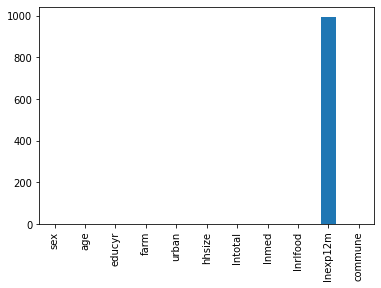

In [5]:
train.isna().sum().plot(kind='bar');

## EDA

- **Examine the distribution of the dependent variable "lntotal"**

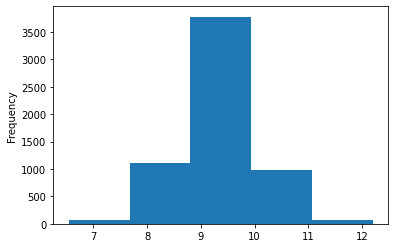

In [6]:
train['lntotal'].plot(kind='hist', bins=5)
plt.show()

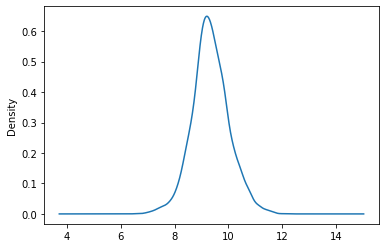

In [7]:
train['lntotal'].plot(kind='density');

The dependent variable "lntotal" is approximately **symetric** (mean ~ mode ~ median). In other words, it sticks to the **normal distribution**.

In [8]:
print(f'- Mean of lntotal: {train["lntotal"].mean()}')
print(f'- Median of lntotal: {train["lntotal"].median()}')
print(f'- Mode of lntotal: {train["lntotal"].mode().values[0]}')

- Mean of lntotal: 9.341561220536763
- Median of lntotal: 9.311416
- Mode of lntotal: 8.665059


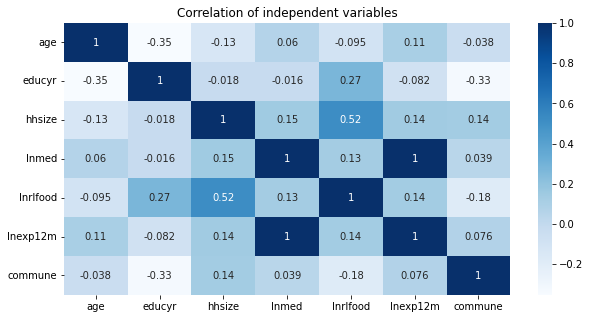

In [9]:
train_corr = train.drop(['lntotal', 'farm', 'sex', 'urban'], axis=1).corr()

plt.figure(figsize=(10, 5))
sns.heatmap(train_corr, annot=True, cmap='Blues')
plt.title('Correlation of independent variables')
plt.show()

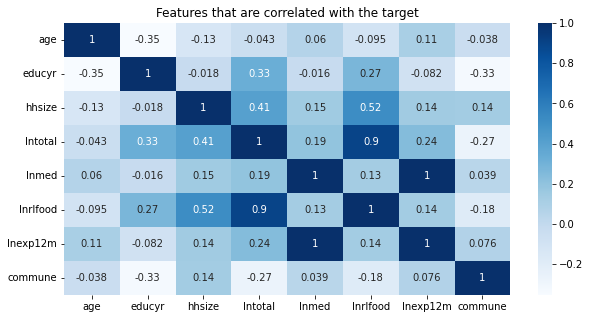

In [10]:
df_corr = train.drop(['farm', 'sex', 'urban'], axis=1).corr()
plt.figure(figsize=(10, 5))
sns.heatmap(df_corr, annot=True, cmap='Blues')
plt.title('Features that are correlated with the target')
plt.show()

- "lnrflood" feature is **highly correlated** with the target "lntotal"

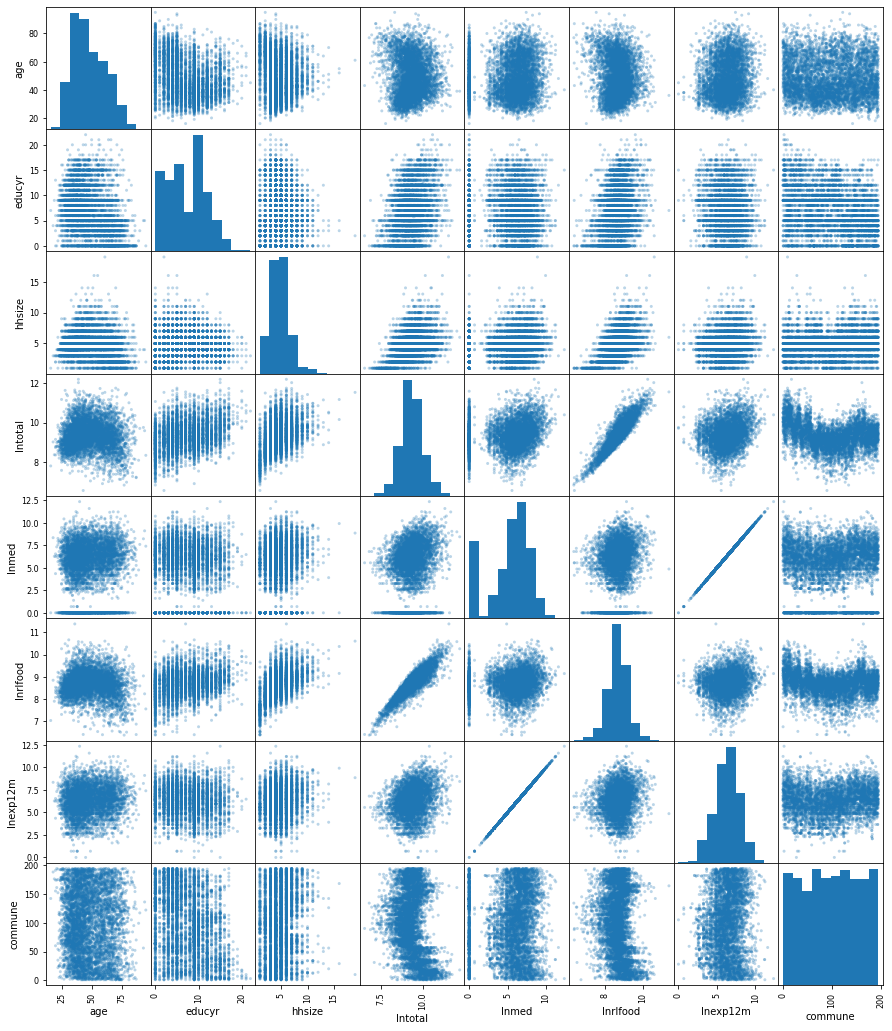

In [11]:
pd.plotting.scatter_matrix(train.drop(['farm', 'sex', 'urban'], axis=1),
                           figsize=(15, 18), 
                           alpha=0.3, 
                           range_padding=0.1)
plt.savefig('scatter_matrix.png')

## Encode categorical data

In [12]:
train['sex'] = train['sex'].map({'male':1, 'female':0})
train['farm'] = train['farm'].map({'yes':1, 'no':0})
train['urban'] = train['urban'].map({'yes':1, 'no':0})
train.head()

,sex,age,educyr,farm,urban,hhsize,lntotal,lnmed,lnrlfood,lnexp12m,commune
0,0,68,4.0,0,1,6,10.13649,11.233210,8.639339,11.233210,1
1,0,57,8.0,0,1,6,10.25206,8.505120,9.345752,8.505120,1
2,1,42,14.0,0,1,6,10.93231,8.713418,10.226330,8.713418,1
3,0,72,9.0,0,1,6,10.26749,9.291736,9.263722,9.291736,1
4,0,73,1.0,0,1,8,10.48811,7.555382,9.592890,7.555382,1


## Impute missing values with KNNImputer

In [13]:
features = ['sex', 'age', 'educyr', 'farm', 'urban', 
            'hhsize', 'lnmed', 'lnrlfood', 'lnexp12m', 'commune']

In [14]:
knn_imp = KNNImputer(n_neighbors=5)
data = knn_imp.fit_transform(train[features])

In [15]:
train_imputed = pd.DataFrame(data=data, columns=features)
train_imputed['lntotal'] = train['lntotal']
train = train_imputed
train

,sex,age,educyr,farm,urban,hhsize,lnmed,lnrlfood,lnexp12m,commune,lntotal
0,0.0,68.0,4.0,0.0,1.0,6.0,11.233210,8.639339,11.233210,1.0,10.136490
1,0.0,57.0,8.0,0.0,1.0,6.0,8.505120,9.345752,8.505120,1.0,10.252060
2,1.0,42.0,14.0,0.0,1.0,6.0,8.713418,10.226330,8.713418,1.0,10.932310
3,0.0,72.0,9.0,0.0,1.0,6.0,9.291736,9.263722,9.291736,1.0,10.267490
4,0.0,73.0,1.0,0.0,1.0,8.0,7.555382,9.592890,7.555382,1.0,10.488110
...,...,...,...,...,...,...,...,...,...,...,...
5994,1.0,48.0,6.0,1.0,0.0,9.0,8.867709,9.130001,8.867709,194.0,9.995432
5995,1.0,21.0,0.0,0.0,0.0,3.0,7.328437,8.249589,7.328437,194.0,8.816945
5996,1.0,37.0,4.0,1.0,0.0,8.0,8.144679,8.558669,8.144679,194.0,9.273211
5997,1.0,42.0,8.0,1.0,0.0,6.0,6.061457,8.858996,6.061457,194.0,9.540550


In [16]:
train.isna().sum()

sex         0
age         0
educyr      0
farm        0
urban       0
hhsize      0
lnmed       0
lnrlfood    0
lnexp12m    0
commune     0
lntotal     0
dtype: int64

## Build a regression model using LightGBM

**Setup KFold**

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

fold = 1
for train_idx, val_idx in tqdm(kf.split(train['lntotal'])):
    train.loc[train.index.isin(val_idx), 'fold'] = fold
    fold +=1 

train['fold'] = train['fold'].astype(int)
train.head()

0it [00:00, ?it/s]

,sex,age,educyr,farm,urban,hhsize,lnmed,lnrlfood,lnexp12m,commune,lntotal,fold
0,0.0,68.0,4.0,0.0,1.0,6.0,11.233210,8.639339,11.233210,1.0,10.13649,4
1,0.0,57.0,8.0,0.0,1.0,6.0,8.505120,9.345752,8.505120,1.0,10.25206,2
2,1.0,42.0,14.0,0.0,1.0,6.0,8.713418,10.226330,8.713418,1.0,10.93231,5
3,0.0,72.0,9.0,0.0,1.0,6.0,9.291736,9.263722,9.291736,1.0,10.26749,2
4,0.0,73.0,1.0,0.0,1.0,8.0,7.555382,9.592890,7.555382,1.0,10.48811,1


**Create out-of-fold**

In [18]:
oof = train[['fold', 'lntotal']]
oof

,fold,lntotal
0,4,10.136490
1,2,10.252060
2,5,10.932310
3,2,10.267490
4,1,10.488110
...,...,...
5994,1,9.995432
5995,3,8.816945
5996,4,9.273211
5997,2,9.540550


**Build the model**

In [19]:
regs, mse_scores, fis = [], [], []

for fold in tqdm(range(1, 6)):
    
    print(f'======== Running for fold {fold} ==========')
    
    X_train = train.query('fold != @fold')[features]
    y_train = train.query('fold != @fold')['lntotal']
    X_val = train.query('fold == @fold')[features]
    y_val = train.query('fold == @fold')['lntotal']
    
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    
    
    reg = lgb.LGBMRegressor(n_estimators=100_000,
                            learning_rate=0.1,
                            objective ='mse',
                            metrics=['l2'],
                            random_state=1,
                            reg_alpha=0.1234532,
                            reg_lambda=0.533267221,
                            importance_type='gain',
                            n_jobs=-1)
    
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['mse'],
            early_stopping_rounds=10,
            verbose=10)
    
    fold_preds = reg.predict(X_val, num_iteration=reg.best_iteration_)
    oof.loc[oof['fold'] == fold, 'fold_preds'] = fold_preds
    
    fold_score = mean_squared_error(oof.query('fold == @fold')['fold_preds'],
                                     oof.query('fold == @fold')['lntotal'])
    
    fi = pd.DataFrame(data=reg.feature_importances_,
                      index=reg.feature_name_,
                      columns=[f'{fold}_importance'])
    
    print(f'- Best iteration: {reg.best_iteration_}')
    print(f'- MSE: {fold_score:.3f}\n')

    mse_scores.append(fold_score) 
    fis.append(fi)
    regs.append(reg)
    
    if fold == 5:
        print(f'Mean MSE: {np.mean(mse_scores):.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

======== Running for fold 1 ==========
(4799, 10) (4799,) (1200, 10) (1200,)
[10]	training's l2: 0.112127	valid_1's l2: 0.11856
[20]	training's l2: 0.0588823	valid_1's l2: 0.069053
[30]	training's l2: 0.0474405	valid_1's l2: 0.0603018
[40]	training's l2: 0.0421933	valid_1's l2: 0.0579951
[50]	training's l2: 0.0391697	valid_1's l2: 0.0572443
- Best iteration: 50
- MSE: 0.057

======== Running for fold 2 ==========
(4799, 10) (4799,) (1200, 10) (1200,)
[10]	training's l2: 0.111539	valid_1's l2: 0.118538
[20]	training's l2: 0.0587618	valid_1's l2: 0.0700992
[30]	training's l2: 0.0474875	valid_1's l2: 0.0607055
[40]	training's l2: 0.0424705	valid_1's l2: 0.057733
- Best iteration: 47
- MSE: 0.057

======== Running for fold 3 ==========
(4799, 10) (4799,) (1200, 10) (1200,)
[10]	training's l2: 0.112438	valid_1's l2: 0.120426
[20]	training's l2: 0.0605079	valid_1's l2: 0.0654844
[30]	training's l2: 0.0490796	valid_1's l2: 0.0547219
[40]	training's l2: 0.0438674	valid_1's l2: 0.0509573
[50]	t

**The last step is to intuitively see and compare the out-of-fold with the ground truth**

In [20]:
oof

,fold,lntotal,fold_preds
0,4,10.136490,10.044905
1,2,10.252060,10.381399
2,5,10.932310,11.252326
3,2,10.267490,10.341279
4,1,10.488110,10.540776
...,...,...,...
5994,1,9.995432,9.863159
5995,3,8.816945,8.896067
5996,4,9.273211,9.283730
5997,2,9.540550,9.534060


## Feature Importance

In [21]:
importances = pd.concat(fis, axis=1)
importances

,1_importance,2_importance,3_importance,4_importance,5_importance
sex,7.177322,4.511224,6.834673,4.669054,3.806763
age,47.917883,53.838322,67.814717,42.676653,52.174275
educyr,141.535696,122.602851,130.083807,146.238202,137.398983
farm,42.983078,38.183383,48.737711,47.675416,43.634347
urban,43.839814,28.561945,40.232176,59.850334,40.348203
hhsize,12.825400,16.929027,15.379465,11.720463,12.094872
lnmed,217.328214,218.249788,229.255200,215.870080,243.480688
lnrlfood,9670.230482,9669.939528,9474.740898,9675.304529,9749.176242
lnexp12m,33.798705,52.532215,53.041698,31.910538,43.619189
commune,707.162712,726.736446,686.181444,659.250486,720.307890


In [22]:
importances.mean(axis=1)

sex            5.399807
age           52.884370
educyr       135.571908
farm          44.242787
urban         42.566494
hhsize        13.789845
lnmed        224.836794
lnrlfood    9647.878336
lnexp12m      42.980469
commune      699.927796
dtype: float64

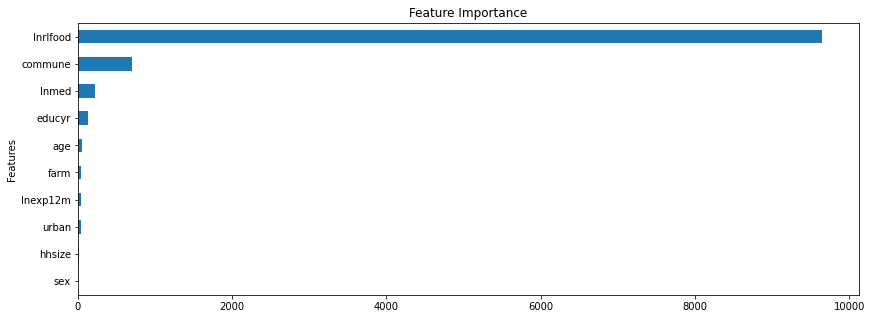

In [23]:
importances.mean(axis=1).sort_values().plot(kind='barh', 
                                            figsize=(14, 5),
                                            title='Feature Importance',
                                            xlabel='Features');

- We see that "Infood" is the **most important feature** for LightGBM model. while it's also highly correlated with the target, which is examined above. 